In [1]:
import os
import cv2
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/imet-2019-fgvc6/train.csv')
labels = pd.read_csv('../input/imet-2019-fgvc6/labels.csv')
test = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')

train["attribute_ids"] = train["attribute_ids"].apply(lambda x:x.split(" "))
train["id"] = train["id"].apply(lambda x: x + ".png")
test["id"] = test["id"].apply(lambda x: x + ".png")

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 0.0001
HEIGHT = 64
WIDTH = 64
CANAL = 3
N_CLASSES = labels.shape[0]
ES_PATIENCE = 5
DECAY_DROP = 0.5
DECAY_EPOCHS = 10
classes = list(map(str, range(N_CLASSES)))

In [4]:
def f2_score_thr(threshold=0.5):
    def f2_score(y_true, y_pred):
        beta = 2
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

        true_positives = K.sum(K.clip(y_true * y_pred, 0, 1), axis=1)
        predicted_positives = K.sum(K.clip(y_pred, 0, 1), axis=1)
        possible_positives = K.sum(K.clip(y_true, 0, 1), axis=1)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))
    return f2_score


def custom_f2(y_true, y_pred):
    beta = 2

    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f2 = (1+beta**2)*p*r / (p*beta**2 + r + 1e-15)

    return f2

def step_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = DECAY_DROP
    epochs_drop = DECAY_EPOCHS
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",    
    classes=classes,
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/imet-2019-fgvc6/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 81928 images belonging to 1103 classes.
Found 27309 images belonging to 1103 classes.
Found 7443 images.


### Model

In [6]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = VGG16(weights=None, include_top=False,
                   input_tensor=input_tensor)
    base_model.load_weights('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='sigmoid', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [7]:
# warm up model
# first: train only the top layers (which were randomly initialized)
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
    
optimizer = optimizers.Adam(lr=LEARNING_RATE)
metrics = ["accuracy", "categorical_accuracy"]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=ES_PATIENCE)
callbacks = [es]
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)

#### Train top layers

In [8]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=2,
                              callbacks=callbacks,
                              verbose=2,
                              max_queue_size=16, workers=3, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
 - 472s - loss: 0.0572 - acc: 0.9835 - categorical_accuracy: 0.0372 - val_loss: 0.0150 - val_acc: 0.9971 - val_categorical_accuracy: 0.0238
Epoch 2/2
 - 455s - loss: 0.0162 - acc: 0.9971 - categorical_accuracy: 0.0549 - val_loss: 0.0145 - val_acc: 0.9971 - val_categorical_accuracy: 0.0462


#### Fine-tune the complete model

In [9]:
for layer in model.layers:
    layer.trainable = True

metrics = ["accuracy", "categorical_accuracy"]
lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=(3))
callbacks = [es]
optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [10]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=(EPOCHS*0.9),
                              callbacks=callbacks,
                              verbose=2,
                              max_queue_size=16, workers=3, use_multiprocessing=True)

Epoch 1/27
 - 477s - loss: 0.0143 - acc: 0.9971 - categorical_accuracy: 0.0882 - val_loss: 0.0126 - val_acc: 0.9972 - val_categorical_accuracy: 0.1290
Epoch 2/27
 - 455s - loss: 0.0129 - acc: 0.9972 - categorical_accuracy: 0.1271 - val_loss: 0.0119 - val_acc: 0.9973 - val_categorical_accuracy: 0.1437
Epoch 3/27
 - 471s - loss: 0.0122 - acc: 0.9972 - categorical_accuracy: 0.1484 - val_loss: 0.0114 - val_acc: 0.9973 - val_categorical_accuracy: 0.1610
Epoch 4/27
 - 460s - loss: 0.0117 - acc: 0.9973 - categorical_accuracy: 0.1673 - val_loss: 0.0112 - val_acc: 0.9973 - val_categorical_accuracy: 0.1712
Epoch 5/27
 - 472s - loss: 0.0115 - acc: 0.9973 - categorical_accuracy: 0.1759 - val_loss: 0.0111 - val_acc: 0.9973 - val_categorical_accuracy: 0.1811
Epoch 6/27
 - 474s - loss: 0.0113 - acc: 0.9973 - categorical_accuracy: 0.1803 - val_loss: 0.0109 - val_acc: 0.9973 - val_categorical_accuracy: 0.1718
Epoch 7/27
 - 460s - loss: 0.0108 - acc: 0.9974 - categorical_accuracy: 0.1960 - val_loss: 0.0

In [11]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=(ES_PATIENCE-2))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=(ES_PATIENCE))
callbacks = [es, rlrop]
optimizer = optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)

In [12]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=(EPOCHS*0.1),
                              callbacks=callbacks,
                              verbose=2,
                              max_queue_size=16, workers=3, use_multiprocessing=True)

Epoch 1/3
 - 471s - loss: 0.0081 - acc: 0.9978 - categorical_accuracy: 0.3143 - val_loss: 0.0103 - val_acc: 0.9974 - val_categorical_accuracy: 0.2345
Epoch 2/3
 - 466s - loss: 0.0080 - acc: 0.9979 - categorical_accuracy: 0.3218 - val_loss: 0.0103 - val_acc: 0.9974 - val_categorical_accuracy: 0.2327
Epoch 3/3
 - 451s - loss: 0.0080 - acc: 0.9979 - categorical_accuracy: 0.3172 - val_loss: 0.0102 - val_acc: 0.9974 - val_categorical_accuracy: 0.2369


### Build complete model

### Complete model graph loss

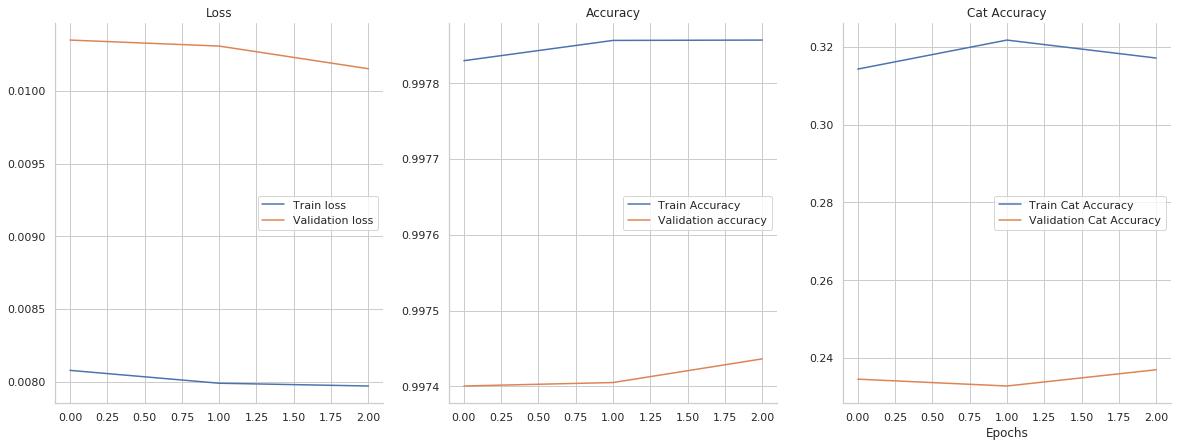

In [13]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['acc'], label='Train Accuracy')
ax2.plot(history.history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history.history['categorical_accuracy'], label='Train Cat Accuracy')
ax3.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
ax3.legend(loc='best')
ax3.set_title('Cat Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Find best threshold value

In [14]:
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
print(lastFullValPred.shape, lastFullValLabels.shape)

(27309, 1103) (27309, 1103)


thr=0.130 F2=0.454


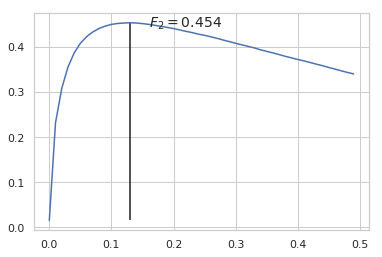

In [15]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    score = []
    thrs = np.arange(0, 0.5, 0.01)
    for thr in thrs:
        score.append(custom_f2(targs, (preds > thr).astype(int)))
    score = np.array(score)
    pm = score.argmax()
    best_thr, best_score = thrs[pm], score[pm].item()
    print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
    if do_plot:
        plt.plot(thrs, score)
        plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
        plt.text(best_thr+0.03, best_score-0.01, f'$F_{2}=${best_score:.3f}', fontsize=14);
        plt.show()
    return best_thr, best_score

threshold, best_score = find_best_fixed_threshold(lastFullValPred, lastFullValLabels, do_plot=True)

### Apply model to test set and output predictions

In [16]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)

In [17]:
predictions = []
for pred_ar in preds:
    valid = []
    for idx, pred in enumerate(pred_ar):
        if pred > threshold:
            valid.append(idx)
    if len(valid) == 0:
        valid.append(np.argmax(pred_ar))
    predictions.append(valid)

In [18]:
filenames = test_generator.filenames
label_map = {valid_generator.class_indices[k] : k for k in valid_generator.class_indices}

results = pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results['attribute_ids'] = results['attribute_ids'].apply(lambda x: list(map(label_map.get, x)))
results["attribute_ids"] = results["attribute_ids"].apply(lambda x: ' '.join(x))
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,1039 1059 121 223 369 587 766
1,100fbe75ed8fd887,1039 1085 188
2,101b627524a04f19,182 482 497 498 718 79 813
3,10234480c41284c6,1046 111 13 147 480 483 51 737 738 776 830 923
4,1023b0e2636dcea8,1046 156 227 393 477 51 584 671 780 954
5,1039cd6cf85845c,1092 13 405 896 903
6,103a5b3f83fbe88,1092 194 51 747 813
7,10413aaae8d6a9a2,1092 147 813 896
8,10423822b93a65ab,147 156 189
9,1052bf702cb099f7,1099 188 428 535 597
